# Next Step

1. Tthe prediction model
2. Remove outliers?, log_transform costs?
3. Integrate this into the existing PTO pipeline.
4. A simple maximizing linear utility with SPO


---

# TODO
Use LR, or this simple NN.

In [39]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

import warnings
warnings.filterwarnings("ignore")

from myutil import *
from features import *

In [40]:
df = pd.read_csv('data/data.csv')

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

In [41]:
df = df[(df['risk_score_t'] > 0.1) & (df['g_continuous'] > 0.1)]

# subset a sample of 5000 rows of df
df = df.sample(n=500, random_state=1)

df.shape

(500, 168)

In [42]:
all_features = df[get_all_features(df)]
feats = all_features.values
risk = df['risk_score_t'].values
gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.ones(risk.shape)

alpha = 0.5
Q = 1e3

utility = risk * gainF * decision

In [43]:
# d = cp.Variable(decision.shape, nonneg=True)
# if alpha != 1:
#     objective = cp.Maximize(cp.sum(cp.multiply(cp.multiply(gainF, risk), d)) ** (1 - alpha) / (1 - alpha))
# else:
#     objective = cp.Maximize(cp.sum(cp.log(cp.multiply(cp.multiply(gainF, risk), d))))

# constraints = [d >= 0, cp.sum(cost * d) <= Q, d <= 1]

# problem = cp.Problem(objective, constraints)
# problem.solve(solver=cp.SCS, max_iters=4000,verbose=False)

# optimal_decision = d.value
# print("Optimal Decision:", optimal_decision)
# print("Optimal Objective Value:", problem.value)

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class RiskDataset(Dataset):
    def __init__(self, features, risks):
        self.features = torch.FloatTensor(features)
        self.risks = torch.FloatTensor(risks).reshape(-1, 1)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.risks[idx]
    
class RiskPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.ReLU()  # Ensure the output is non-negative
        )
    
    def forward(self, x):
        return self.model(x)

# Training function
def train_model(features, risks, epochs=10, batch_size=32):
    dataset = RiskDataset(features, risks)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = RiskPredictor(features.shape[1])
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        for batch_features, batch_risks in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_features)
            loss = criterion(predictions, batch_risks)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model


model = train_model(feats, risk)

def AlphaFairness(util,alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha)/(1-alpha))

Epoch [5/10], Loss: 49.9997
Epoch [10/10], Loss: 54.9044


In [45]:
def solve_optimization(gainF, risk, cost, alpha, Q):
    # Flatten input arrays
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)
    
    utils = cp.multiply(cp.multiply(gainF, risk), d)
    
    if alpha == 'inf':
        # Maximin formulation
        t = cp.Variable()  # auxiliary variable for minimum utility
        objective = cp.Maximize(t)
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q,
            utils >= t  # t is the minimum utility
        ]
    elif alpha == 1:
        # Nash welfare (alpha = 1)
        objective = cp.Maximize(cp.sum(cp.log(utils)))
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q
        ]
    else:
        # General alpha-fairness
        objective = cp.Maximize(cp.sum(utils**(1-alpha))/(1-alpha) if alpha != 0 
                              else cp.sum(utils))
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q
        ]
    
    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=False)
    
    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")
    
    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)
    
    return optimal_decision, optimal_value

In [46]:
loss = 0
optsum = 0

# predict the risk
model.eval()
predicted_risk = model(torch.FloatTensor(feats)).detach().numpy()

predicted_risk.mean()

0.0027822296

In [47]:
risk.flatten()

array([ 0.73042297, 12.00951249,  1.37591303,  2.56497367,  1.1381009 ,
        0.526584  ,  9.08782062,  0.84932903,  2.00441651, 11.89060642,
        5.58858502,  7.01545779,  3.09155767,  5.02802786,  7.74588075,
        6.70969934,  2.2762018 ,  4.9940547 ,  2.07236283,  1.80057754,
        2.76881264,  0.88330219,  3.99184644,  4.50144386,  0.47562426,
        2.17428232,  2.32716154,  2.70086632,  1.93647019,  2.37812128,
        4.09376592,  1.25700696,  3.07457109,  2.68387974,  0.95124851,
        5.80941057, 15.61066757, 16.49396976,  5.40173263,  3.22745031,
        3.61814167,  0.96823509,  4.77322915,  7.2702565 ,  0.93426193,
        0.526584  ,  3.90691354,  2.29318838,  3.34635638,  3.05758451,
        5.40173263,  1.71564464,  3.61814167,  6.9135383 ,  9.69933752,
        0.59453032,  2.87073212,  0.6115169 , 13.77611687,  0.57754374,
        5.40173263, 14.47256667,  1.61372516,  0.86631561,  2.15729574,
        7.77985392,  1.29098013,  5.89434347,  1.91948361,  8.93

In [48]:
print("decision shape:", decision.shape)
print("gainF shape:", gainF.shape)
print("risk shape:", risk.shape)

decision shape: (500,)
gainF shape: (500,)
risk shape: (500,)


In [49]:
# pred_sol,_ = solve_optimization(gainF, predicted_risk, cost, alpha='inf', Q=Q)
# pred_obj = np.sum((risk * gainF * pred_sol)**(1-alpha)/(1-alpha))
# true_obj = np.sum((optimal_decision * gainF * risk)**(1-alpha)/(1-alpha))

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

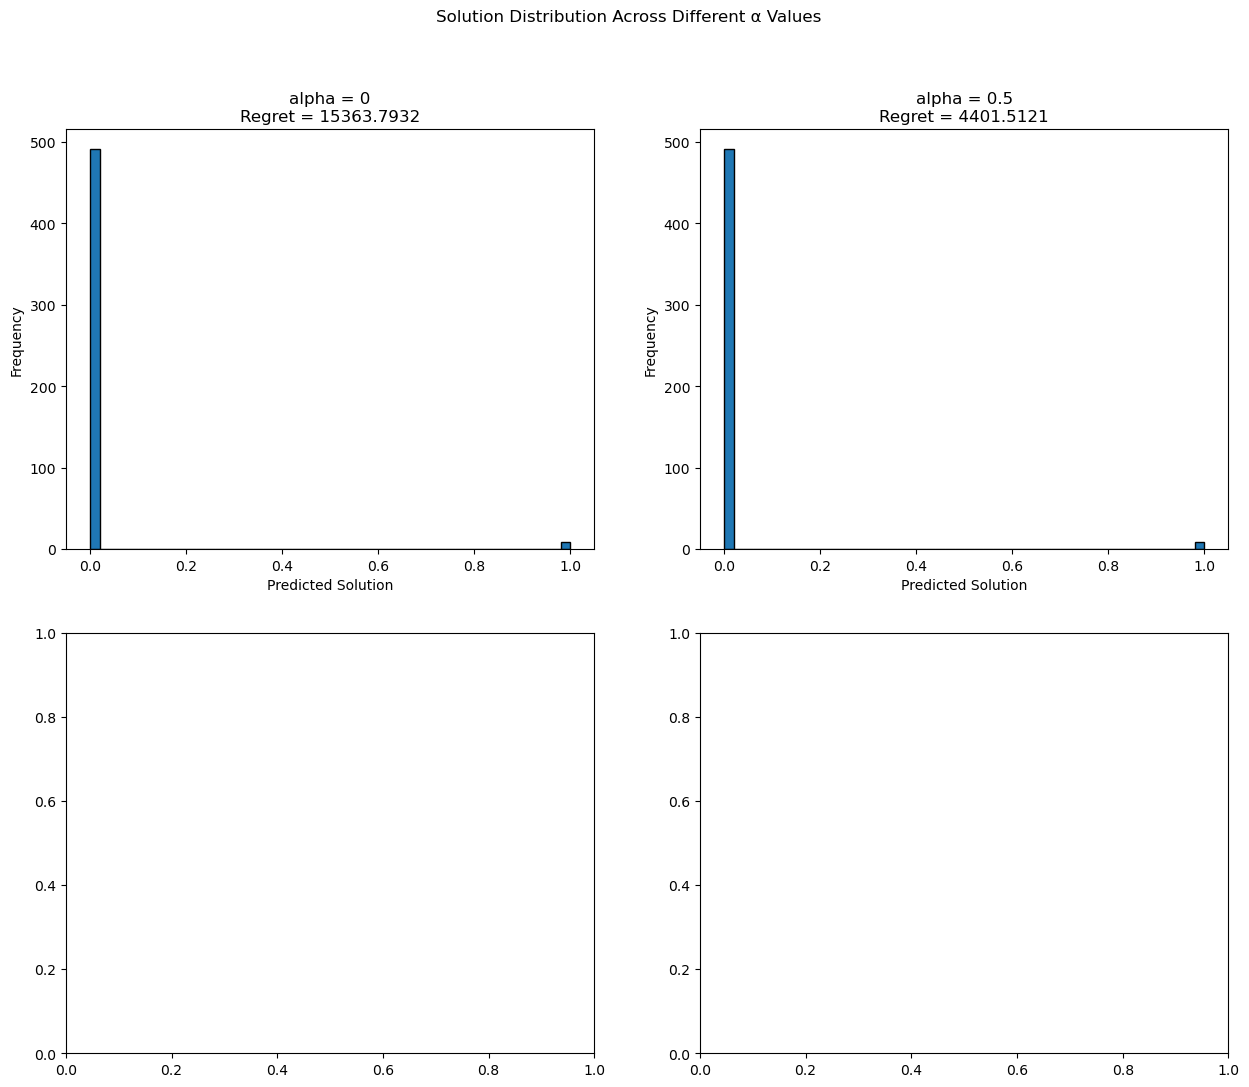

In [50]:
def analyze_alpha_fairness(model, feats, gainF, risk, cost, Q):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Solution Distribution Across Different α Values')

    alphas = [0, 0.5, 1, 'inf']
    regrets = []

    model.eval()
    predicted_risk = model(torch.FloatTensor(feats)).detach().numpy()

    opt_sol, opt_val = solve_optimization(gainF, risk, cost, alpha='inf', Q=Q)
    
    for idx, alpha in enumerate(alphas):
        row = idx // 2
        col = idx % 2
        
        pred_sol, _ = solve_optimization(gainF, predicted_risk, cost, alpha, Q)
        
        # Calculate objectives
        if alpha != 'inf':
            if alpha == 1:
                pred_obj = np.sum(np.log(risk * gainF * pred_sol))
                true_obj = np.sum(np.log(risk * gainF * opt_sol))
            elif alpha == 0:
                pred_obj = np.sum(risk * gainF * pred_sol)
                true_obj = np.sum(risk * gainF * opt_sol)
            else:
                pred_obj = np.sum((risk * gainF * pred_sol)**(1-alpha)/(1-alpha))
                true_obj = np.sum((opt_sol * gainF * risk)**(1-alpha)/(1-alpha))
        else:
            pred_obj = np.min(risk * gainF * pred_sol)
            true_obj = np.min(risk * gainF * opt_sol)
        
        regret = true_obj - pred_obj
        regrets.append((alpha, regret, true_obj, pred_obj))
        
        axes[row, col].hist(pred_sol, bins=50, edgecolor='k')
        axes[row, col].set_xlabel('Predicted Solution')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_title(f'alpha = {alpha}\nRegret = {regret:.4f}')
        
    plt.tight_layout()
    
    for alpha, regret, true_obj, pred_obj in regrets:
        print(f'Alpha: {alpha}, Regret: {regret:.4f}, True Objective: {true_obj:.4f}, Predicted Objective: {pred_obj:.4f}')
    
    return fig, regrets

fig, regrets = analyze_alpha_fairness(model, feats, gainF, risk, cost, Q)
plt.show()

regrets

# SPO

In [51]:
# Why is the predicted objective zero or even more fair?
alpha = 'inf'
regret = 0
model.eval()

predicted_risk = model(torch.FloatTensor(feats)).detach().numpy()
predicted_risk.flatten()
opt_sol, opt_val = solve_optimization(gainF, risk, cost, alpha='inf', Q=Q)

In [52]:
print("Mean:", np.mean(predicted_risk))
print("Standard Deviation:", np.std(predicted_risk))
print("Min:", np.min(predicted_risk))
print("Max:", np.max(predicted_risk))

Mean: 0.0027822296
Standard Deviation: 0.020608721
Min: 0.0
Max: 0.16730969


In [53]:
opt_sol, opt_val

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

In [55]:
import numpy as np
import cvxpy as cp

def AlphaFairness(util, alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha)/(1-alpha))

def solve_optimization(gainF, risk, cost, alpha, Q):
    # Flatten input arrays
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)
    utils = cp.multiply(cp.multiply(gainF, risk), d)

    if alpha == 'inf':
        # Maximin formulation
        t = cp.Variable()  # auxiliary variable for minimum utility
        objective = cp.Maximize(t)
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q,
            utils >= t  # t is the minimum utility
        ]
    elif alpha == 1:
        # Nash welfare (alpha = 1)
        objective = cp.Maximize(cp.sum(cp.log(utils)))
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q
        ]
    else:
        # General alpha-fairness
        objective = cp.Maximize(cp.sum((utils)**(1-alpha))/(1-alpha) if alpha != 0
                                else cp.sum(utils))
        constraints = [
            d >= 0,
            d <= 1,
            cp.sum(cost * d) <= Q
        ]

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    d.value = np.ones(risk.shape) * (Q / np.sum(cost))
    problem.solve(solver=cp.MOSEK, warm_start=True,
                  mosek_params={'MSK_IPAR_LOG': 1}, verbose=True)

    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")

    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)

    return optimal_decision, optimal_value


In [66]:
opt_sol, opt_val = solve_optimization(gainF, risk, cost, alpha=2, Q=1e2)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) Jan 05 04:15:54 PM: Your problem has 500 variables, 3 constraints, and 0 parameters.
(CVXPY) Jan 05 04:15:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 05 04:15:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 05 04:15:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 05 04:15:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 05 04:15:54 PM: Compiling problem (target solver=MOSEK).
(C